In [1]:
import cv2 
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
import os
import pickle
import joblib
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def get_img_paths(path, train):
    image_paths = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            img = cv2.imread(file_path,0)
            
            if (img is not None):
                image_paths.append(file_path)
                
    if (train is True):
        np.random.shuffle(image_paths)
        
    return image_paths

In [3]:
indices = {"aquarium":0,"desert":1,"highway":2,"kitchen":3,"laundromat":4,"park":5,"waterfall":6,"windmill":7}

def get_labels(images):
    labels = []
    for img in images:
        for i in indices.keys():
            if (i in img):
                labels.append(indices[i])
    return labels

In [4]:
train_path = "../dataset/train"
test_path = "../dataset/test"
train_images = []
test_images = []

In [5]:
train_list = get_img_paths(train_path,True)
test_list = get_img_paths(test_path,False)
train_labels = get_labels(train_list)
test_labels = get_labels(test_list)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

print(len(train_list))
print(train_labels.shape)
print(len(test_list))
print(test_labels.shape)

640
(640,)
160
(160,)


In [6]:
def get_SIFT_features(image_paths, sample = 10):
    desc_list = []
    sift = cv2.SIFT_create()
    for pat in image_paths:
        gray = cv2.imread(pat,0)
        if (gray is not None):
            kp = []
            h = 150
            w = 150
            gray_r = cv2.resize(gray,(h,w))
            kp = [cv2.KeyPoint(x, y, sample) for y in range(0, h, sample) 
                                    for x in range(0, w, sample)]
            kp_1,des = sift.compute(gray_r,kp)
            desc_list.append(des)
    return desc_list

In [7]:
def get_descriptors_array(desc_list):
    des_arr = np.array(desc_list[0])
    for desc in desc_list[1:]:
        des_arr = np.vstack((des_arr, desc))
        
    return des_arr

In [8]:
def kmeans_desc(des_arr, num_clus):
    kmeans = KMeans(n_clusters = num_clus).fit(des_arr)
    return kmeans

In [9]:
def extr_feat(kmeans,desc_list,num_clus):
    im_feat = [np.zeros(num_clus) for i in range(len(desc_list))]
    for i in range(len(desc_list)):
        for j in range(len(desc_list[i])):
            feat = desc_list[i][j]
            feat = feat.reshape(1, 128)
            idx = kmeans.predict(feat)
            im_feat[i][idx] += 1
            
    return im_feat

## Number of Clusters = 600, Sampling Frequency of SIFT = 10

In [10]:
num_clus = 600

img_feats = get_SIFT_features(train_list)
print (len(img_feats))

desc_arr = get_descriptors_array(img_feats)
print ("Starting clustering...")
kmeans = kmeans_desc(desc_arr, num_clus)

print ("Finished clustering")

im_feats = extr_feat(kmeans,img_feats,num_clus)

640
Starting clustering...
Finished clustering


In [11]:
def findSVM(im_feats, train_labels):
    svm_model = SVC(C = 10, gamma = "auto", kernel="linear")
    clf = OneVsRestClassifier(svm_model)
    scale = StandardScaler()
    X_norm = scale.fit_transform(im_feats)
    clf.fit(X_norm, train_labels)
    
    return clf, X_norm, scale

In [12]:
clf, X_norm, scale = findSVM(im_feats, train_labels)

In [13]:
y_preds = clf.predict(X_norm)
train_acc = accuracy_score(train_labels, y_preds)

print ("Training accuracy:",train_acc)

Training accuracy: 1.0


In [14]:
test_feats = get_SIFT_features(test_list)
print(len(test_feats))

test_hist = extr_feat(kmeans, test_feats, num_clus)
X_norm_test = scale.transform(test_hist)
y_test = clf.predict(test_hist)

test_acc = accuracy_score(test_labels, y_test)

160
Test accuracy:  0.5875


In [51]:
best_acc = np.max(best_acc, test_acc)
print("Best Test accuracy: ", best_acc)

Best Test accuracy:  0.671875


In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_norm,train_labels,test_size = 0.30, random_state = 101)
print(len(X_train))
print(len(X_val))

448
192


In [16]:
'''
def best_params_select(X_train, y_train):
    
    Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    gammas = [0.1, 0.11, 0.095, 0.105,"auto","scale"]
    param_grid = {'C': Cs, 'gamma': gammas,'kernel': ['linear']} 

    grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

    grid.fit(X_train, y_train)
    print(grid.best_estimator_)
    return grid
'''

In [17]:
'''
grid = best_params_select(X_train, y_train)
'''

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] C=0.5, gamma=0.1, kernel=linear .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... C=0.5, gamma=0.1, kernel=linear, score=0.622, total=   0.3s
[CV] C=0.5, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.5, gamma=0.1, kernel=linear, score=0.656, total=   0.2s
[CV] C=0.5, gamma=0.1, kernel=linear .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] ..... C=0.5, gamma=0.1, kernel=linear, score=0.689, total=   0.2s
[CV] C=0.5, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.5, gamma=0.1, kernel=linear, score=0.584, total=   0.2s
[CV] C=0.5, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.5, gamma=0.1, kernel=linear, score=0.685, total=   0.3s
[CV] C=0.5, gamma=0.11, kernel=linear ................................
[CV] .... C=0.5, gamma=0.11, kernel=linear, score=0.622, total=   0.3s
[CV] C=0.5, gamma=0.11, kernel=linear ................................
[CV] .... C=0.5, gamma=0.11, kernel=linear, score=0.656, total=   0.2s
[CV] C=0.5, gamma=0.11, kernel=linear ................................
[CV] .... C=0.5, gamma=0.11, kernel=linear, score=0.689, total=   0.3s
[CV] C=0.5, gamma=0.11, kernel=linear ................................
[CV] .... C=0.5, gamma=0.11, kernel=linear, score=0.584, total=   0.2s
[CV] C=0.5, gamma=0.11, kernel=linear ................................
[CV] .

[CV] .... C=0.15, gamma=0.1, kernel=linear, score=0.622, total=   0.3s
[CV] C=0.15, gamma=0.1, kernel=linear ................................
[CV] .... C=0.15, gamma=0.1, kernel=linear, score=0.656, total=   0.3s
[CV] C=0.15, gamma=0.1, kernel=linear ................................
[CV] .... C=0.15, gamma=0.1, kernel=linear, score=0.689, total=   0.2s
[CV] C=0.15, gamma=0.1, kernel=linear ................................
[CV] .... C=0.15, gamma=0.1, kernel=linear, score=0.584, total=   0.3s
[CV] C=0.15, gamma=0.1, kernel=linear ................................
[CV] .... C=0.15, gamma=0.1, kernel=linear, score=0.685, total=   0.3s
[CV] C=0.15, gamma=0.11, kernel=linear ...............................
[CV] ... C=0.15, gamma=0.11, kernel=linear, score=0.622, total=   0.4s
[CV] C=0.15, gamma=0.11, kernel=linear ...............................
[CV] ... C=0.15, gamma=0.11, kernel=linear, score=0.656, total=   0.3s
[CV] C=0.15, gamma=0.11, kernel=linear ...............................
[CV] .

[CV] ... C=0.2, gamma=scale, kernel=linear, score=0.584, total=   0.3s
[CV] C=0.2, gamma=scale, kernel=linear ...............................
[CV] ... C=0.2, gamma=scale, kernel=linear, score=0.685, total=   0.3s
[CV] C=0.3, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.3, gamma=0.1, kernel=linear, score=0.622, total=   0.3s
[CV] C=0.3, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.3, gamma=0.1, kernel=linear, score=0.656, total=   0.2s
[CV] C=0.3, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.3, gamma=0.1, kernel=linear, score=0.689, total=   0.2s
[CV] C=0.3, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.3, gamma=0.1, kernel=linear, score=0.584, total=   0.2s
[CV] C=0.3, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.3, gamma=0.1, kernel=linear, score=0.685, total=   0.3s
[CV] C=0.3, gamma=0.11, kernel=linear ................................
[CV] .

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   39.0s finished


SVC(C=0.5, gamma=0.1, kernel='linear')


In [18]:
'''
val_preds = grid.predict(X_val)
val_acc = accuracy_score(y_val,val_preds)
print ("Validation accuracy: ",val_acc)
'''

Validation accuracy:  0.671875


In [19]:
'''
y_test_2 = grid.predict(test_hist)
test_acc = accuracy_score(test_labels,y_test_2)
print ("Test accuracy: ",test_acc)
'''

Test accuracy:  0.59375


<b>Due to very high number of clusters, the training data fitted almost perfectly and the regularisation parameter was lambda = 1. Therefore, the Training Accuracy was 1.0 and the test accuracy was 0.625.</b>

In [20]:
'''
filename = 'good_acc_model.sav'
joblib.dump(grid, filename)
'''

['good_acc_model.sav']

In [21]:
def plot_hist(im_feats, num_clus):
    x = np.arange(num_clus)
    y = np.array([])
    for h in range(num_clus):
        ans = 0
        for i in range(len(im_feats)):
            ans = ans + im_feats[i][h]
            ans = ans.astype(np.int64)
        y = np.append(y, ans)

    plt.bar(x, y)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary")
    plt.xticks(x + 0.4, x)
    plt.show()

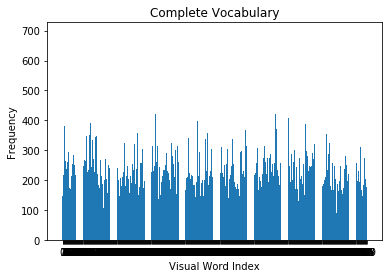

In [22]:
plot_hist(im_feats, num_clus)

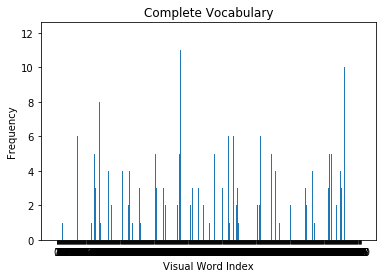

In [23]:
plot_hist(X_norm, num_clus)

In [24]:
def get_conf_matrix(test_labels, y_test, normalise = False):
    conf_mat = np.zeros((8, 8))
    for i in range(len(test_labels)):
            conf_mat[test_labels[i]][y_test[i]] += 1
            
    if normalise is True:
        conf_mat = conf_mat.astype(np.float64)
        conf_mat = conf_mat / (len(test_labels)/8)
  
    return conf_mat

In [25]:
print(test_labels)
print(y_test_2)

[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
[5 5 5 5 7 5 5 5 5 5 6 5 5 5 0 5 7 5 5 0 3 0 3 0 0 4 3 3 3 3 0 6 3 0 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 3 3 4 4 4 4 4 3 4 4 3 2 2 1 2 2 7 2 2 2 1 2 2 2 1
 2 3 2 1 2 2 3 0 7 0 0 0 0 0 0 4 0 0 0 6 0 5 1 4 4 5 6 5 4 6 0 7 6 5 5 0 6
 0 0 6 0 5 5 7 5 1 7 5 1 7 5 7 7 0 7 7 7 7 2 7 7 7 7 7 5 0 2 1 1 2 2 1 5 3
 1 1 1 7 7 0 5 1 6 0 1 6]


In [26]:
conf_mat = get_conf_matrix(test_labels, y_test_2)

print(conf_mat)

[[11.  1.  0.  1.  3.  2.  1.  1.]
 [ 2.  8.  3.  1.  0.  2.  2.  2.]
 [ 0.  4. 14.  1.  0.  0.  0.  1.]
 [ 5.  0.  0. 13.  1.  0.  1.  0.]
 [ 0.  0.  0.  4. 16.  0.  0.  0.]
 [ 2.  0.  0.  0.  0. 15.  1.  2.]
 [ 5.  1.  0.  0.  1.  6.  5.  2.]
 [ 2.  1.  1.  0.  0.  3.  0. 13.]]


In [27]:
conf_mat_norm = get_conf_matrix(test_labels, y_test_2, normalise = True)

print(conf_mat_norm)

[[0.06875 0.00625 0.      0.00625 0.01875 0.0125  0.00625 0.00625]
 [0.0125  0.05    0.01875 0.00625 0.      0.0125  0.0125  0.0125 ]
 [0.      0.025   0.0875  0.00625 0.      0.      0.      0.00625]
 [0.03125 0.      0.      0.08125 0.00625 0.      0.00625 0.     ]
 [0.      0.      0.      0.025   0.1     0.      0.      0.     ]
 [0.0125  0.      0.      0.      0.      0.09375 0.00625 0.0125 ]
 [0.03125 0.00625 0.      0.      0.00625 0.0375  0.03125 0.0125 ]
 [0.0125  0.00625 0.00625 0.      0.      0.01875 0.      0.08125]]


In [28]:
cnt1 = 0
cnt2 = 0

for i in range(len(test_labels)):
    if test_labels[i] == y_test_2[i] and cnt1 < 2:
        print(test_labels[i], y_test_2[i], i)
        cnt1 += 1
    elif test_labels[i] != y_test_2[i] and cnt2 < 2:
        print(test_labels[i], y_test_2[i], i)
        cnt2 += 1
        
cnt1 = 0
cnt2 = 0

for i in range(len(test_labels)):
    if test_labels[i] == y_test_2[i] and test_labels[i] == 4 and cnt1 < 2:
        print(test_labels[i], y_test_2[i], i)
        cnt1 += 1
    elif test_labels[i] != y_test_2[i] and test_labels[i] == 4 and cnt2 < 2:
        print(test_labels[i], y_test_2[i], i)
        cnt2 += 1

5 5 0
5 5 1
5 7 4
5 6 10
4 4 40
4 4 41
4 3 49
4 3 50


Text(0.5, 1.0, 'Laundromat Identified as Park')

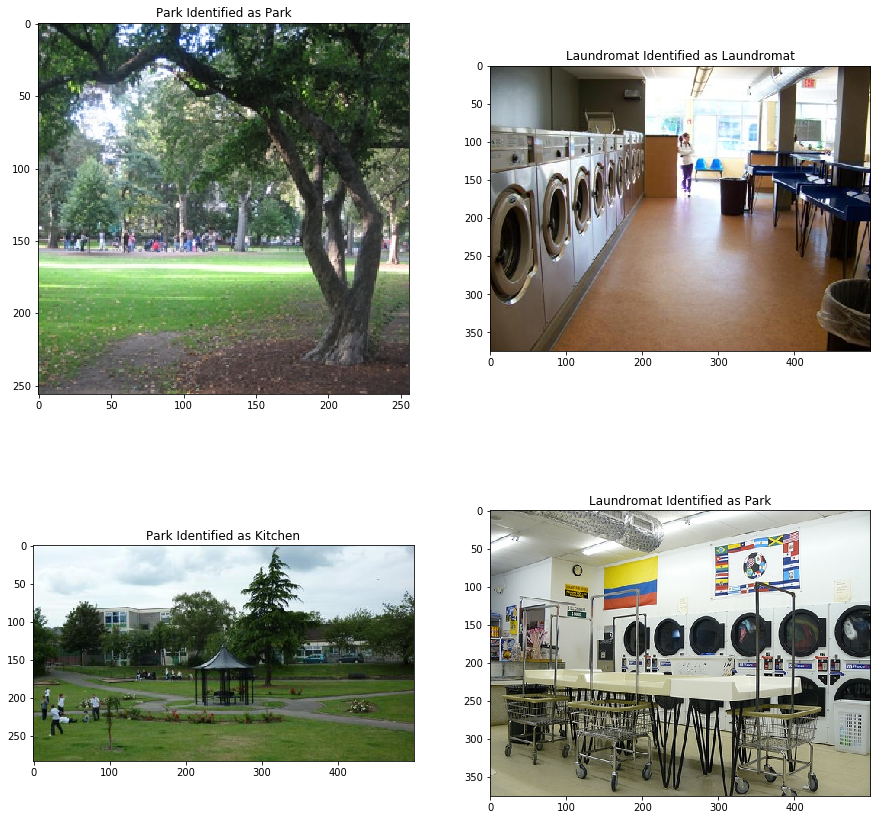

In [29]:
img1_corr = cv2.cvtColor(cv2.imread('../dataset/test/park/sun_azlqdhptzeknzemu.jpg'), cv2.COLOR_BGR2RGB)
img2_corr = cv2.cvtColor(cv2.imread('../dataset/test/laundromat/sun_awuxvlnzusmrmjcl.jpg'), cv2.COLOR_BGR2RGB)

img1_w = cv2.cvtColor(cv2.imread('../dataset/test/park/sun_bbjxopwoqkmqrdjn.jpg'), cv2.COLOR_BGR2RGB)
img2_w = cv2.cvtColor(cv2.imread('../dataset/test/laundromat/sun_ayosbnnjaujulsrd.jpg'), cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize = (15,15))

plt.subplot(2,2,1)
plt.imshow(img1_corr)
plt.title("Park Identified as Park")

plt.subplot(2,2,2)
plt.imshow(img2_corr)
plt.title("Laundromat Identified as Laundromat")

plt.subplot(2,2,3)
plt.imshow(img1_w)
plt.title("Park Identified as Kitchen")

plt.subplot(2,2,4)
plt.imshow(img2_w)
plt.title("Laundromat Identified as Park")

## Number of Clusters = 300, Sampling Frequency of SIFT = 10

In [30]:
num_clus = 300

img_feats = get_SIFT_features(train_list)
print (len(img_feats))

desc_arr = get_descriptors_array(img_feats)
print ("Starting clustering...")
kmeans = kmeans_desc(desc_arr, num_clus)

print ("Finished clustering")

im_feats = extr_feat(kmeans,img_feats,num_clus)

640
Starting clustering...
Finished clustering


In [32]:
clf, X_norm, scale = findSVM(im_feats, train_labels)

y_preds = clf.predict(X_norm)
train_acc = accuracy_score(train_labels, y_preds)

print ("Training accuracy:",train_acc)

Training accuracy: 1.0


In [33]:
test_feats = get_SIFT_features(test_list)
print(len(test_feats))

test_hist = extr_feat(kmeans, test_feats, num_clus)
X_norm_test = scale.transform(test_hist)
y_test = clf.predict(test_hist)

test_acc = accuracy_score(test_labels, y_test)
print("Test accuracy: ", test_acc)

160
Test accuracy:  0.54375


## Number of Clusters = 100, Sampling Frequency of SIFT = 10

In [34]:
num_clus = 100

img_feats = get_SIFT_features(train_list)
print (len(img_feats))

desc_arr = get_descriptors_array(img_feats)
print ("Starting clustering...")
kmeans = kmeans_desc(desc_arr, num_clus)

print ("Finished clustering")

im_feats = extr_feat(kmeans,img_feats,num_clus)

640
Starting clustering...
Finished clustering


In [35]:
clf, X_norm, scale = findSVM(im_feats, train_labels)

y_preds = clf.predict(X_norm)
train_acc = accuracy_score(train_labels, y_preds)

print ("Training accuracy:",train_acc)

Training accuracy: 0.925


In [36]:
test_feats = get_SIFT_features(test_list)
print(len(test_feats))

test_hist = extr_feat(kmeans, test_feats, num_clus)
X_norm_test = scale.transform(test_hist)
y_test = clf.predict(test_hist)

test_acc = accuracy_score(test_labels, y_test)
print("Test accuracy: ", test_acc)

160
Test accuracy:  0.43125


## Number of Clusters = 300, Sampling Frequency of SIFT = 5

In [37]:
num_clus = 300

img_feats = get_SIFT_features(train_list, sample = 5)
print (len(img_feats))

desc_arr = get_descriptors_array(img_feats)
print ("Starting clustering...")
kmeans = kmeans_desc(desc_arr, num_clus)

print ("Finished clustering")

im_feats = extr_feat(kmeans,img_feats,num_clus)

640
Starting clustering...
Finished clustering


In [38]:
clf, X_norm, scale = findSVM(im_feats, train_labels)

y_preds = clf.predict(X_norm)
train_acc = accuracy_score(train_labels, y_preds)

print ("Training accuracy:",train_acc)

Training accuracy: 1.0


In [39]:
test_feats = get_SIFT_features(test_list)
print(len(test_feats))

test_hist = extr_feat(kmeans, test_feats, num_clus)
X_norm_test = scale.transform(test_hist)
y_test = clf.predict(test_hist)

test_acc = accuracy_score(test_labels, y_test)
print("Test accuracy: ", test_acc)

160
Test accuracy:  0.39375


## Number of Clusters = 300, Sampling Frequency of SIFT = 20

In [40]:
num_clus = 300

img_feats = get_SIFT_features(train_list, sample = 20)
print (len(img_feats))

desc_arr = get_descriptors_array(img_feats)
print ("Starting clustering...")
kmeans = kmeans_desc(desc_arr, num_clus)

print ("Finished clustering")

im_feats = extr_feat(kmeans,img_feats,num_clus)

640
Starting clustering...
Finished clustering


In [41]:
clf, X_norm, scale = findSVM(im_feats, train_labels)

y_preds = clf.predict(X_norm)
train_acc = accuracy_score(train_labels, y_preds)

print ("Training accuracy:",train_acc)

Training accuracy: 1.0


In [42]:
test_feats = get_SIFT_features(test_list)
print(len(test_feats))

test_hist = extr_feat(kmeans, test_feats, num_clus)
X_norm_test = scale.transform(test_hist)
y_test = clf.predict(test_hist)

test_acc = accuracy_score(test_labels, y_test)
print("Test accuracy: ", test_acc)

160
Test accuracy:  0.41875


## SVM REGULARISATION PARAMETER GAMMA = 0.1

In [43]:
def findSVM_new(im_feats, train_labels):
    svm_model = SVC(C = 10, gamma = 0.1, kernel="linear")
    clf = OneVsRestClassifier(svm_model)
    scale = StandardScaler()
    X_norm = scale.fit_transform(im_feats)
    clf.fit(X_norm, train_labels)
    
    return clf, X_norm, scale

In [44]:
num_clus = 300

img_feats = get_SIFT_features(train_list)
print (len(img_feats))

desc_arr = get_descriptors_array(img_feats)
print ("Starting clustering...")
kmeans = kmeans_desc(desc_arr, num_clus)

print ("Finished clustering")

im_feats = extr_feat(kmeans,img_feats,num_clus)

640
Starting clustering...
Finished clustering


In [45]:
clf, X_norm, scale = findSVM_new(im_feats, train_labels)

y_preds = clf.predict(X_norm)
train_acc = accuracy_score(train_labels, y_preds)

print ("Training accuracy:",train_acc)

Training accuracy: 1.0


In [46]:
test_feats = get_SIFT_features(test_list)
print(len(test_feats))

test_hist = extr_feat(kmeans, test_feats, num_clus)
X_norm_test = scale.transform(test_hist)
y_test = clf.predict(test_hist)

test_acc = accuracy_score(test_labels, y_test)
print("Test accuracy: ", test_acc)

160
Test accuracy:  0.59375


## SVM REGULARISATION PARAMETER C = 8.8, GAMMA = 0.2

In [47]:
def findSVM_new2(im_feats, train_labels):
    svm_model = SVC(C = 8.8, gamma = 0.02, kernel="linear")
    clf = OneVsRestClassifier(svm_model)
    scale = StandardScaler()
    X_norm = scale.fit_transform(im_feats)
    clf.fit(X_norm, train_labels)
    
    return clf, X_norm, scale

In [48]:
num_clus = 300

img_feats = get_SIFT_features(train_list)
print (len(img_feats))

desc_arr = get_descriptors_array(img_feats)
print ("Starting clustering...")
kmeans = kmeans_desc(desc_arr, num_clus)

print ("Finished clustering")

im_feats = extr_feat(kmeans,img_feats,num_clus)

640
Starting clustering...
Finished clustering


In [49]:
clf, X_norm, scale = findSVM_new2(im_feats, train_labels)

y_preds = clf.predict(X_norm)
train_acc = accuracy_score(train_labels, y_preds)

print ("Training accuracy:",train_acc)

Training accuracy: 1.0


In [50]:
test_feats = get_SIFT_features(test_list)
print(len(test_feats))

test_hist = extr_feat(kmeans, test_feats, num_clus)
X_norm_test = scale.transform(test_hist)
y_test = clf.predict(test_hist)

test_acc = accuracy_score(test_labels, y_test)
print("Test accuracy: ", test_acc)

160
Test accuracy:  0.58125
